## Question 1: Propensity score matching

In this exercise, you will apply propensity score matching, which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "Evaluating the Econometric Evaluations of Training Programs" (1986). The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program. Your task is to determine the effectiveness of the "treatment" represented by the job training program.

### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the "Design of Observational Studies". Even just reading the first chapter (18 pages) will help you a lot.

In [19]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import folium
import re
import sys
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.linear_model.logistic 
from sklearn.model_selection import cross_val_predict, cross_val_score

#### 1. A naive analysis

Compare the distribution of the outcome variable (re78) between the two groups, using plots and numbers. To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [2]:
def validation_hypothesis(prob, feature):
    threshold_prob = 0.005
    if (prob>threshold_prob):
        print "The null-hypothesis is validated, the mean of both cases of",feature, "can be considered identical. P-value =",prob
        return True
    else:
        print "The null-hypothesis is rejected, the mean of both cases of",feature, "are not identical. P-value =",prob
        return False

In [3]:
def compare_distributions(treat0, treat1, feature, feature_cols):
    fig, ax_ = plt.subplots(figsize=(20,5))

    # We create an histogram for each cases
    treat0.hist(feature, ax = ax_, alpha = 0.5)
    treat1.hist(feature, ax = ax_, alpha = 0.5)

    ax_.legend(('Not participating in the program', 'Participating in the program'))
    plt.show()
    
    # We calculate the t-test with the null-hypothesis that the mean of both distributions is the same.
    t, prob = ttest_ind(treat0[feature], treat1[feature])
    
    # For question 3, we only keep the desired columns
    if (validation_hypothesis(prob, feature)):
        feature_cols.append(feature)
        
    return feature_cols

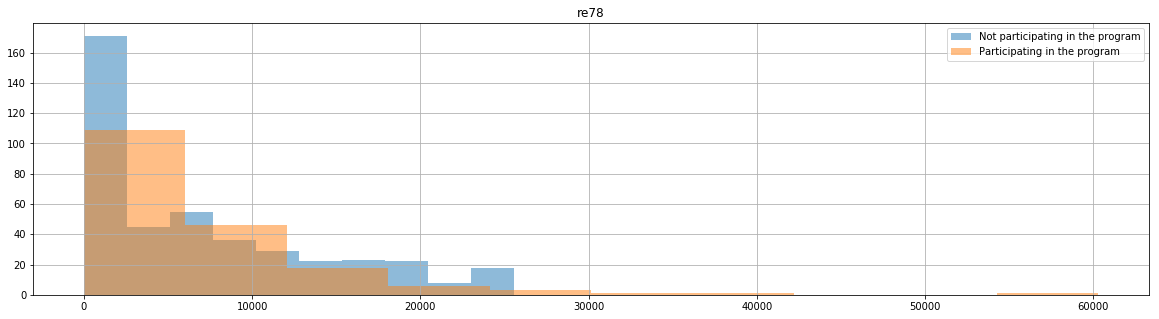

The null-hypothesis is validated, the mean of both cases of re78 can be considered identical. P-value = 0.334249668591


In [4]:
CSV_PATH = 'lalonde.csv'

londe_df = pd.read_csv(CSV_PATH) 

# Create a different dataset for the treated persons and the others
treat1 = londe_df[londe_df['treat']==1]
treat0 = londe_df[londe_df['treat']==0]

# Create a feature vector that stores the meaningful columns
feature_cols = []

feature = 're78'
feature_cols = compare_distributions(treat0,treat1,feature, feature_cols)

By looking at the distributions for both cases, we can obseve that they look rather similar. The case where the people were not participating in the program seems more dense with a revenue between 0 and 25'000 in 1978, whereas in the other case some people received more, with some outliers around 60'000.
If we look at the t-test, we observe a test statistic of 0.97 and a p-value of 0.33. Our hypothesis that both distribution have equal mean is validated as the p-value stays above our common significance level of 1% (As we have a one-tailed distribution, we measure half of 1%, which is 0.005).

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above. You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers. As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe? Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

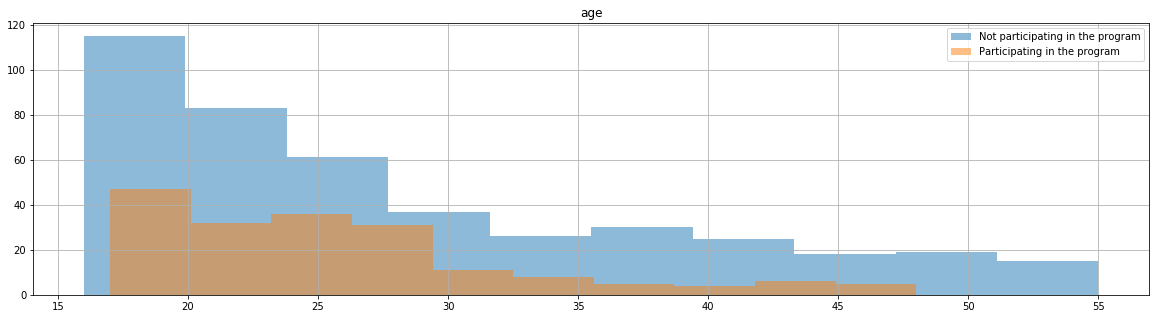

The null-hypothesis is validated, the mean of both cases of age can be considered identical. P-value = 0.0107363325824


In [5]:
feature = 'age'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

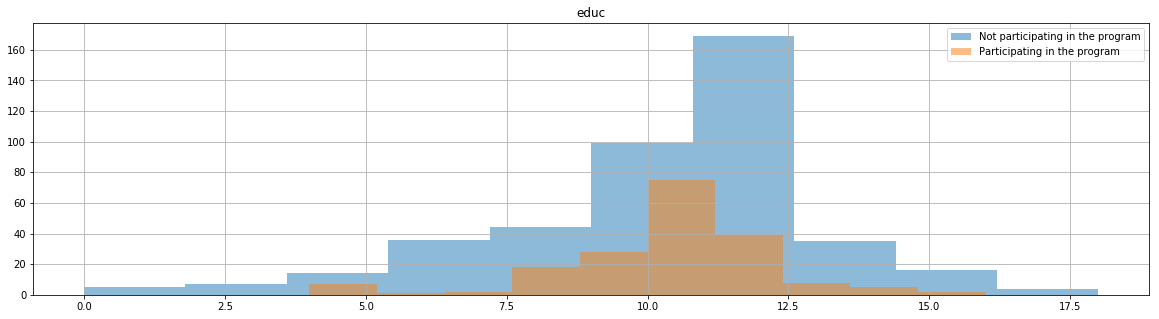

The null-hypothesis is validated, the mean of both cases of educ can be considered identical. P-value = 0.633000972047


In [6]:
feature = 'educ'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

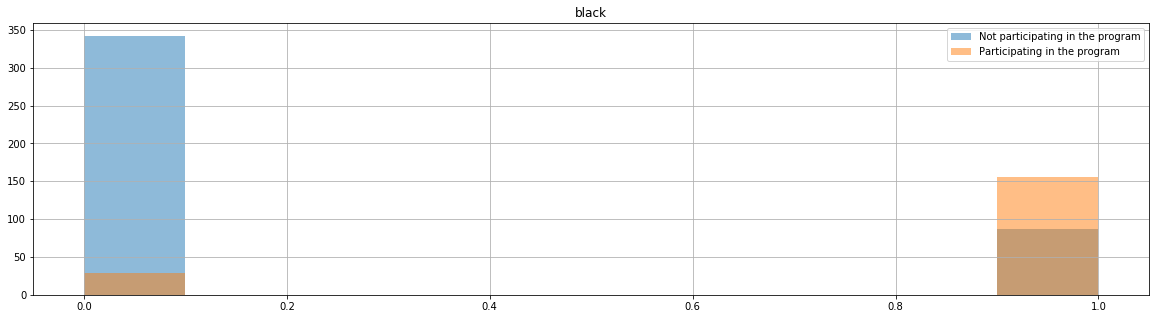

The null-hypothesis is rejected, the mean of both cases of black are not identical. P-value = 1.56007825122e-61


In [7]:
feature = 'black'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

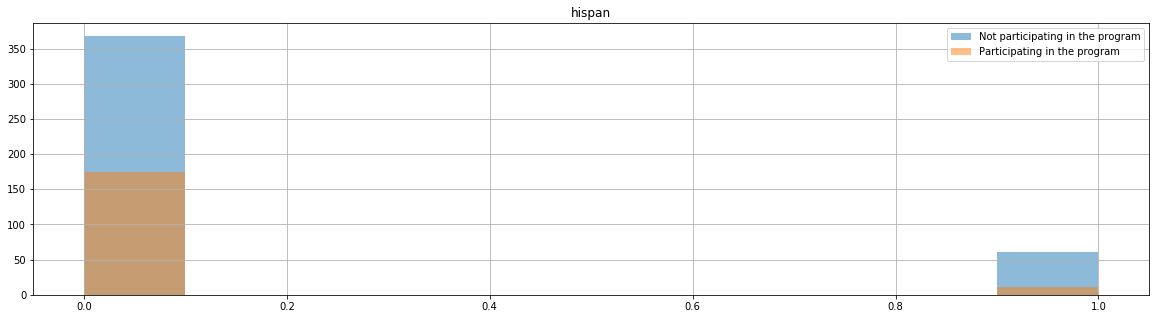

The null-hypothesis is rejected, the mean of both cases of hispan are not identical. P-value = 0.00341386049709


In [8]:
feature = 'hispan'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

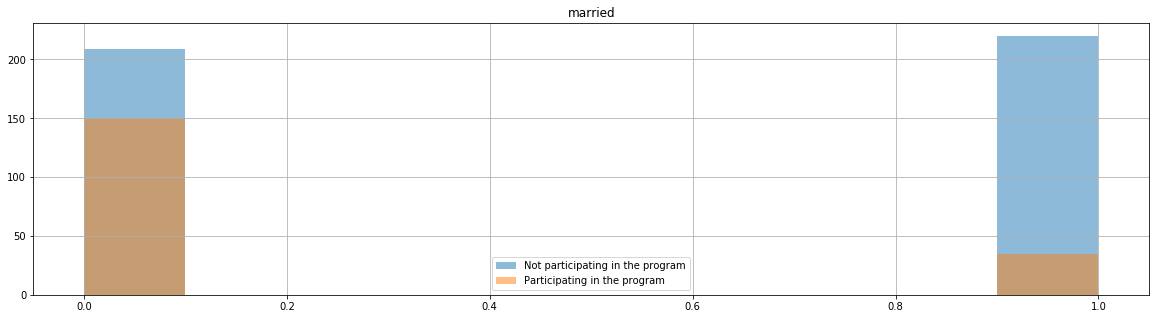

The null-hypothesis is rejected, the mean of both cases of married are not identical. P-value = 2.35512414069e-14


In [9]:
feature = 'married'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

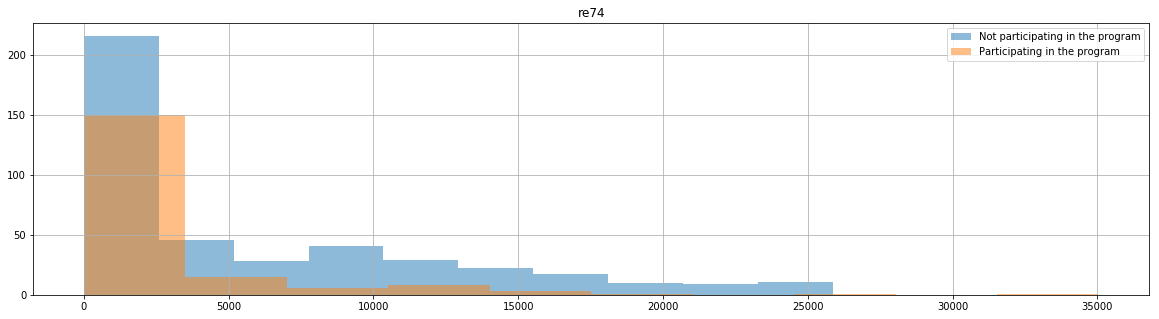

The null-hypothesis is rejected, the mean of both cases of re74 are not identical. P-value = 3.46458525776e-10


In [10]:
feature = 're74'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

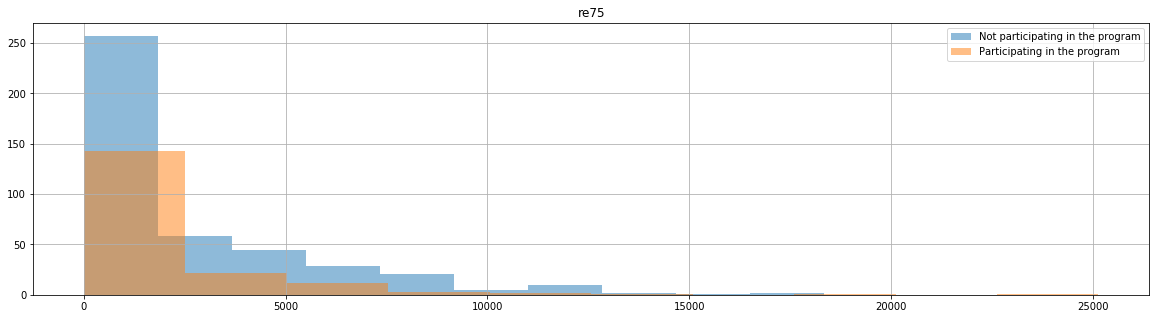

The null-hypothesis is rejected, the mean of both cases of re75 are not identical. P-value = 0.00122344439485


In [11]:
feature = 're75'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

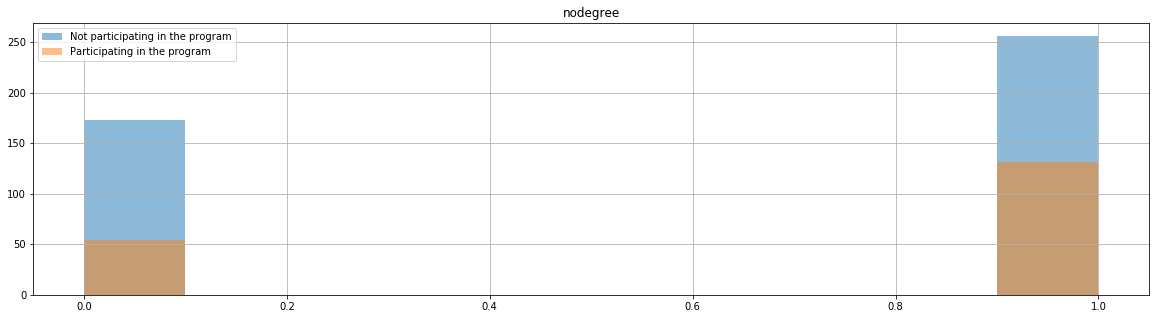

The null-hypothesis is validated, the mean of both cases of nodegree can be considered identical. P-value = 0.00866309085702


In [12]:
feature = 'nodegree'
feature_cols = compare_distributions(treat0,treat1,feature,feature_cols)

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset. You may use sklearn to fit the logistic regression model and apply it to each data point to obtain propensity scores:

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.). To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or this article.

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. It's sole purpose is to balance the dataset across treatment groups. (See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores. If you want even more information, read this article.)

In [32]:
# All features "age","educ","black","hispan","married","nodegree","re74","re75","re78"
X = londe_df[feature_cols]
y = londe_df.treat

logistic = LogisticRegression()
logistic.fit(X,y)
prediction = -X.dot(logistic.coef_.T)

In [44]:
lr = LinearRegression()
predicted = cross_val_predict(lr, X, y, cv=5)
prediction = []

for i in range(0,predicted.shape[0]):
    if predicted[i] >0.5:
        prediction.append(1)
    else:
        prediction.append(0)

predicted

array([ 0.17390125,  0.16750738,  0.06760306,  0.1931107 ,  0.12922615,
        0.16746223,  0.083325  ,  0.18353008,  0.15595511,  0.06313592,
        0.1727502 ,  0.10318   ,  0.15771233,  0.17427329,  0.14157685,
        0.19097121,  0.09204319,  0.18294482,  0.05001381,  0.07657998,
        0.20143519,  0.08414344,  0.13687668,  0.19934281,  0.19209063,
        0.18910687,  0.19667071,  0.17501796,  0.19349233,  0.19944041,
        0.19508204,  0.02920954,  0.1974865 ,  0.08901655,  0.07921777,
        0.080741  ,  0.0906173 ,  0.08274554,  0.10428786,  0.18180175,
        0.08699639,  0.17225863,  0.15881932,  0.15743905,  0.20673736,
        0.19764082,  0.15960952,  0.17734578,  0.09002863,  0.08285027,
        0.13874048,  0.18546497,  0.21092112,  0.07930038,  0.18809699,
        0.19508204,  0.13929744,  0.04241795,  0.08146032,  0.20322961,
        0.15960952,  0.13665471,  0.16047532,  0.19379261,  0.06582347,
        0.15542848,  0.19384645,  0.13049014,  0.0524418 ,  0.08

In [36]:
predicted[4]

0.12922615199723222

#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group. (Hint: you may explore the networkx package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores. In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects. Compare the outcomes (re78) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects. What do you observe? Are you closer to being able to draw valid conclusions now than you were before?

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching? Would you say your dataset is sufficiently balanced? If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature. Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### 6. A less naive analysis

Compare the outcomes (re78) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5. What do you conclude about the effectiveness of the job training program?